In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
print(chars)
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s,i in stoi.items()}
print(itos)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### build the dataset

In [5]:
block_size = 3
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.dtype, X.shape, Y.dtype, Y.shape)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .
torch.int64 torch.Size([32, 3]) torch.int64 torch.Size([32])


In [6]:
C = torch.randn((27,2))

In [7]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.9542,  0.4690])

In [8]:
print(X.shape)
print(C[X].shape)
print(Y.shape)
print(C[Y].shape)

torch.Size([32, 3])
torch.Size([32, 3, 2])
torch.Size([32])
torch.Size([32, 2])


In [9]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
print(W1.shape, b1.shape)

torch.Size([6, 100]) torch.Size([100])


In [10]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
print(h.shape)

torch.Size([32, 100])


In [11]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [12]:
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
print(loss.item())

19.37701416015625


In [13]:
print(F.cross_entropy(logits, Y))

tensor(19.3770)


In [14]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [15]:
sum(p.nelement() for p in parameters)

3481

In [16]:
lr = 0.1
for _ in range(100):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

17.769712448120117
13.656402587890625
11.298768997192383
9.452457427978516
7.984262466430664
6.891321182250977
6.1000142097473145
5.452036380767822
4.8981523513793945
4.414663791656494
3.985849380493164
3.6028308868408203
3.2621419429779053
2.961381435394287
2.6982972621917725
2.469712734222412
2.271660566329956
2.101283550262451
1.9571772813796997
1.8374860286712646
1.7380964756011963
1.6535115242004395
1.5790901184082031
1.5117661952972412
1.4496049880981445
1.3913118839263916
1.3359922170639038
1.2830530405044556
1.2321914434432983
1.183381199836731
1.1367988586425781
1.092664361000061
1.0510923862457275
1.0120266675949097
0.9752703309059143
0.940556526184082
0.907612681388855
0.8761921525001526
0.8460891842842102
0.817135751247406
0.7891989946365356
0.7621747851371765
0.7359814047813416
0.7105578780174255
0.6858609914779663
0.6618654131889343
0.6385656595230103
0.6159818768501282
0.5941656827926636
0.5732104778289795
0.553256094455719
0.5344879627227783
0.5171167850494385
0.5013313

### build full dataset

In [17]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.dtype, X.shape, Y.dtype, Y.shape)
    return X, Y

In [18]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

### gradient descent

In [19]:
lr = 0.1
X, Y = build_dataset(words)
for epoch in range(100):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(epoch, loss.item())
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

torch.int64 torch.Size([228146, 3]) torch.int64 torch.Size([228146])
0 19.505229949951172
1 17.08448600769043
2 15.776532173156738
3 14.833340644836426
4 14.002608299255371
5 13.253263473510742
6 12.57991886138916
7 11.983102798461914
8 11.47049331665039
9 11.05185604095459
10 10.709587097167969
11 10.407631874084473
12 10.127808570861816
13 9.864364624023438
14 9.614501953125
15 9.376439094543457
16 9.148944854736328
17 8.931110382080078
18 8.722230911254883
19 8.521749496459961
20 8.329227447509766
21 8.144325256347656
22 7.966791152954102
23 7.796450614929199
24 7.633184909820557
25 7.476907730102539
26 7.327521800994873
27 7.184885025024414
28 7.04879093170166
29 6.918952465057373
30 6.795018196105957
31 6.676602840423584
32 6.563317775726318
33 6.454790115356445
34 6.350668907165527
35 6.250643253326416
36 6.15443229675293
37 6.06178617477417
38 5.972482681274414
39 5.886328220367432
40 5.803147315979004
41 5.722784519195557
42 5.645094394683838
43 5.5699462890625
44 5.49721384048

### gradient descent on mini batch
### first select a range for learning rate

tensor([[-3.0000e+00,  1.0000e-03],
        [-2.9970e+00,  1.0069e-03],
        [-2.9940e+00,  1.0139e-03],
        ...,
        [-6.0060e-03,  9.8627e-01],
        [-3.0030e-03,  9.9311e-01],
        [ 0.0000e+00,  1.0000e+00]])


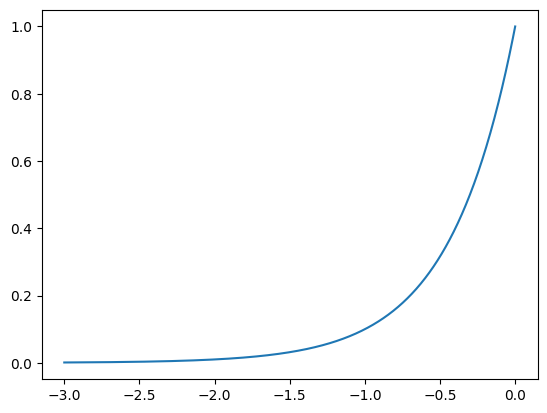

In [24]:
lre = torch.linspace(torch.log10(torch.tensor(0.001)), torch.log10(torch.tensor(1.0)), 1000)
lrs = 10**lre
print(torch.vstack((lre, lrs)).transpose(1, 0))
plt.plot(lre, lrs)

In [25]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

### train with the selected learning rate values

In [26]:
lossi = []
lri = []
for epoch in range(1000):
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    lossi.append(loss.item())
    print(epoch, loss.item())
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward()
    lri.append(lre[epoch])
    lr = lrs[epoch]
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

0 20.814573287963867
1 19.040109634399414
2 18.795610427856445
3 22.688913345336914
4 20.194934844970703
5 17.139198303222656
6 18.142518997192383
7 20.368406295776367
8 19.871252059936523
9 20.1878604888916
10 19.191152572631836
11 20.16490364074707
12 15.860907554626465
13 21.848094940185547
14 18.443443298339844
15 18.576765060424805
16 20.536109924316406
17 17.892004013061523
18 19.367807388305664
19 20.012659072875977
20 19.176761627197266
21 19.08856964111328
22 16.878225326538086
23 17.75770378112793
24 18.522621154785156
25 18.429262161254883
26 18.89443016052246
27 19.01971435546875
28 20.349971771240234
29 16.771711349487305
30 17.518749237060547
31 17.569944381713867
32 19.263917922973633
33 18.687849044799805
34 17.843399047851562
35 16.020160675048828
36 18.146230697631836
37 17.453916549682617
38 17.775346755981445
39 19.66629409790039
40 19.214468002319336
41 16.051454544067383
42 19.15462875366211
43 16.00457763671875
44 20.040979385375977
45 15.86119270324707
46 17.601

### plot the learning rate and the loss to determine the best learning rate

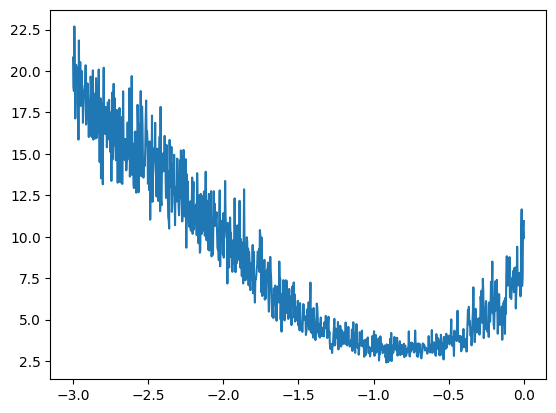

In [27]:
plt.plot(lri, lossi)

### above plot shows that value bw -1.0 and -0.5, for example -0.75 is probably a good learning rate
### train with the selected learning rate

In [38]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [39]:
lossi = []
lr = 10**-0.9 # learning rate 10^(-1.25)
print(f'{lr=}')
for epoch in range(1000):
    # ix = torch.randint(0, X.shape[0], (X.shape[0],))
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    lossi.append(loss.item())
    print(epoch, loss.item())
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward() 
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

lr=0.12589254117941673
0 21.145580291748047
1 17.86044692993164
2 15.348031997680664
3 14.907455444335938
4 15.962881088256836
5 14.324200630187988
6 12.273530006408691
7 11.65623950958252
8 9.434330940246582
9 8.376299858093262
10 10.850504875183105
11 9.127952575683594
12 8.272781372070312
13 7.930008888244629
14 10.239906311035156
15 10.259448051452637
16 9.646163940429688
17 10.660865783691406
18 8.806187629699707
19 7.934886455535889
20 8.703045845031738
21 7.119353294372559
22 6.328866958618164
23 6.5951924324035645
24 6.99551248550415
25 6.745850086212158
26 6.515143394470215
27 6.27199125289917
28 6.6807732582092285
29 6.330204963684082
30 6.188334941864014
31 4.395904064178467
32 6.57728385925293
33 7.63863468170166
34 5.911749839782715
35 5.252829551696777
36 5.628445625305176
37 7.542971134185791
38 4.497187614440918
39 5.26058292388916
40 4.386750221252441
41 4.5488152503967285
42 5.132165431976318
43 4.510653495788574
44 5.1696038246154785
45 4.120438098907471
46 4.9388027

1000


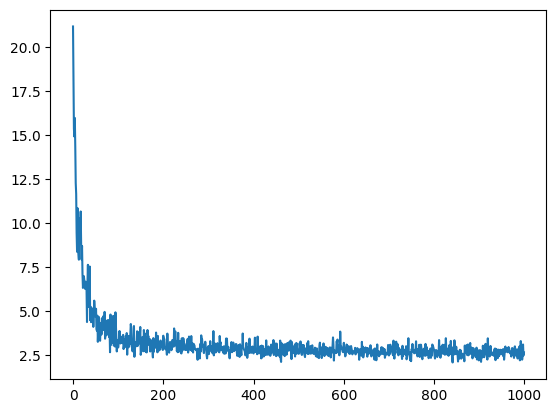

In [40]:
print(len(lossi))
plt.plot(np.arange(len(lossi)).tolist(), lossi)

### dataset split: training set, validation set, testing set
### 80%, 10%, 10%

In [43]:
# words = open('names.txt', 'r').read().splitlines()
# print(len(words))
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
print(n1, n2-n1, len(words)-n2)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

25626 3203 3204
torch.int64 torch.Size([182580, 3]) torch.int64 torch.Size([182580])
torch.int64 torch.Size([22767, 3]) torch.int64 torch.Size([22767])
torch.int64 torch.Size([22799, 3]) torch.int64 torch.Size([22799])


### train only with training set

In [49]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

3481


In [50]:
lossi = []
lr = 10**-1.25 # learning rate 10^(-1.25)
lr = 0.1
print(f'{lr=}')
for epoch in range(40000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    lossi.append(loss.item())
    print(epoch, loss.item())
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward() 
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

lr=0.1
0 20.77838134765625
1 18.451404571533203
2 15.148115158081055
3 14.176264762878418
4 15.31587028503418
5 16.115957260131836
6 14.639570236206055
7 12.879715919494629
8 11.948280334472656
9 12.519783020019531
10 10.915989875793457
11 10.087541580200195
12 8.945296287536621
13 9.991583824157715
14 9.602045059204102
15 9.599925994873047
16 9.736459732055664
17 10.021539688110352
18 9.312636375427246
19 8.95038890838623
20 7.515320301055908
21 9.331689834594727
22 7.70070219039917
23 8.802629470825195
24 8.0023775100708
25 6.844073295593262
26 7.835939884185791
27 7.58846378326416
28 7.198611259460449
29 6.072862148284912
30 8.433114051818848
31 7.228519916534424
32 5.806523323059082
33 6.205848217010498
34 6.994321823120117
35 5.475316524505615
36 7.06783390045166
37 5.8373236656188965
38 6.442104339599609
39 6.047177791595459
40 6.00797176361084
41 5.424556732177734
42 4.4350385665893555
43 4.8612494468688965
44 4.517418384552002
45 5.548361778259277
46 5.717562198638916
47 6.3261

### compute the loss on training and validation/development set

In [51]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.412358045578003


In [52]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.4167098999023438


### increase the n/w size

In [55]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [60]:
stepi = []
lossi = []
lr = 10**-1.25 # learning rate 10^(-1.25)
lr = 0.1/2
print(f'{lr=}')
for step in range(30000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    stepi.append(step)
    lossi.append(loss.item())
    # print(step, loss.item())    
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward() 
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

lr=0.05


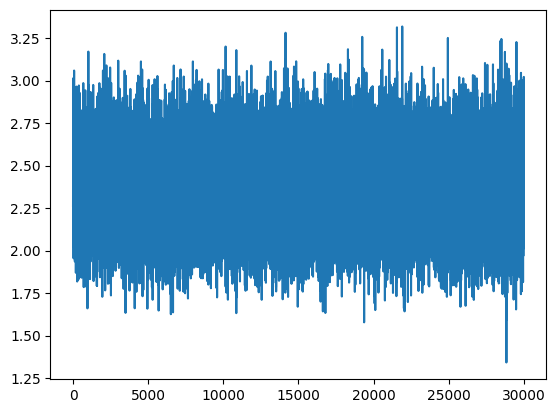

In [61]:
plt.plot(stepi, lossi)

In [62]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.377100944519043
2.3812754154205322


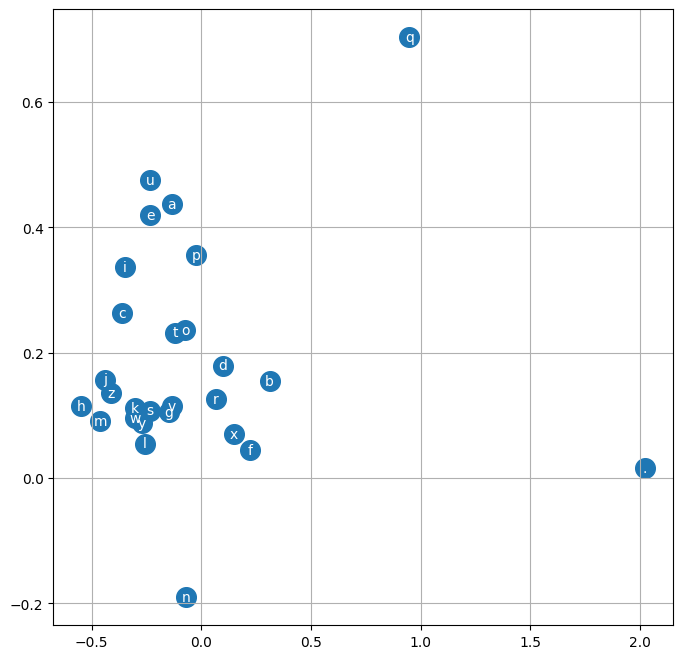

In [74]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

### increase the n/w size

In [70]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [78]:
stepi = []
lossi = []
lr = 10**-1.25 # learning rate 10^(-1.25)
lr = 0.01
print(f'{lr=}')
for step in range(30000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    stepi.append(step)
    lossi.append(loss.item())
    # print(step, loss.item())    
    # backward pass - compute gradient
    for p in parameters:
        p.grad = None
    loss.backward() 
    # update parameters
    for p in parameters:
        p.data -= lr * p.grad

lr=0.01


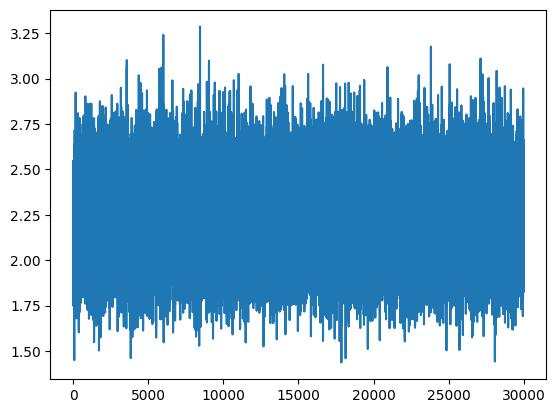

In [79]:
plt.plot(stepi, lossi)

In [80]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.2069954872131348
2.226522445678711
